#  Lab 2 Instructions

In this notebook, we will learn how to do classification of MNIST handwritten digits using TensorFlow 2. The notebook contains all the info that you need to understand the basic mechanism of the classification.

Your are free to tweak the hyper-parameters (including number of hidden units, number of hidden layers, learning rate, num of iterations and so on) to improve the performance of the model. The final block of the code computes the prediction accuracy of the model on the testing set, please do not change this block.

Make sure that your final submission is a notebook that can be run from beginning to end, and you should print out the accuracy at the end of the notebook (i.e. be sure to run the last block after training). It is in fact possible to achieve >98% accuracy on this dataset with a more complex neural network architecture and careful tuning of hyper-parameters. **Your grade will depend on the final prediction accuracy**. However, if you tweak the evaluation code to report false result, you will receive no credit for this assignment.

We encourage the students to take the learnings from here and try some other classification tasks on their own. A number of datasets are available in tensorflow, see here: https://www.tensorflow.org/datasets/catalog/overview. A good dataset to start with is the cifar10 dataset.



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Classification using TensorFlow 2

In the introduction notebook, we walked through how to solve a supervised learning regression problem (i.e. where the labels are continuous values) from scratch. Now, you will build a model that solves a classification problem (i.e. where the labels are discrete values). We will use the MNIST hand written digit dataset, a toy benchmark for image classification models. Let's first load the dataset via the TensorFlow 2 API.

### Dataset
Here $X_{train},Y_{train}$ denote the training data and $X_{test},Y_{test}$ denote the testing data. We train the model on training set and evaluate its performance on testing set (to evaluate potential under-fitting or over-fitting). As can be seen below, $X_{train}$ contains $60000$ examples with $28 \times 28 $ pixels. $Y_{train}$ contains $60000$ corresponding examples with $10$ classes.

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


train_dataloader = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(64)
)
test_dataloader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

print(len(x_train), len(x_test))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
60000 10000


Shape of x:  (28, 28, 1)
Label:  5


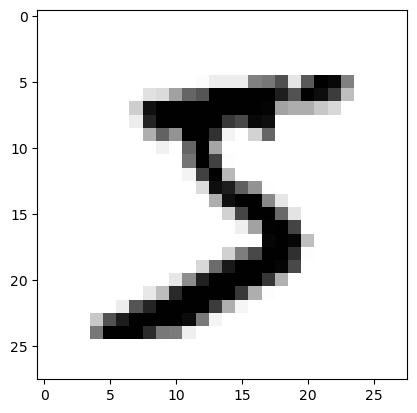

In [ ]:
x, y = x_train[0], y_train[0]
print("Shape of x: ", x.shape)
print("Label: ", y)

plt.imshow(x.squeeze(), cmap="gray_r")

Let's look at a bunch of samples!

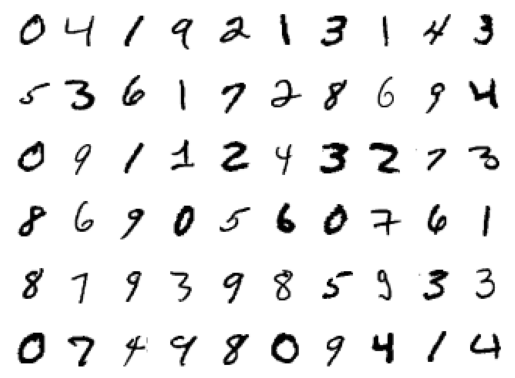

In [ ]:
figure = plt.figure()
num_of_images = 60
for i in range(1, num_of_images + 1):
    x, y = x_train[i], y_train[i]
    plt.subplot(6, 10, i)
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray_r")

### Model
You are responsible for defining the model f(x) = y, where x is an image and y is the digit found in the image. We provide one way to do this, but you will need to explore different model architectures and training strategies to get sufficient performance:

The shape of any image x is 28x28. We can reshape the image so it is instead a vector of length 28*28 = 784. Then, we can use the methods described in the introduction notebook to map a 784-dimensional vector to a 10-dimensional vector of probabilities. The digit in the image will then correspond to the index of the highest probability entry in the predicted 10-dimensional vector.

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(10),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Unlike regression, where the predicted output y is a scalar in $\mathbb{R}$, in classification the model outputs logits or scores, one for each class. In our problem, there are 10 classes so the output of f(x) is a 10-dimensional vector of scores.

In order to convert these scores to probabilities, we can simply normalize. Typically, the softmax operation is used to compute probabilties from logits or scores. After computing the prediction y = f(x), which is a 10-dimensional, we can compute the probability vector p:

$$p_i = \frac{e^{y_i}}{\sum_{j=1}^{10} e^{y_j}}, i=1,\ldots, 10, \text{ or } p=softmax(y)$$

In [6]:
def probabilties_from_scores(y):
    f = tf.nn.softmax
    p = f(y)
    return p

### Loss

For $K$ classes, our labels y in the dataset will take on an integer value between [0,K]. We must convert these values to one-hot representations. For example, when $K=3$, y = 1 as a one-hot vector would be $[1,0,0]$ to represent the first class. If the model predicts a probability $p\in\mathbb{R}^K$ for this training instance, the loss function is

$$L = - \sum_{i=1}^K y_i \log p_i$$

Therefore, in the example where y = 1, L = - probability of the first entry since the one-hot vector is [1, 0, 0]. The loss function motivates assigning high probability to true classes and low probability otherwise.

In [7]:
def loss(y_hat, y):
    # y_hat has shape (N, 10) for 10 classes, y has shape (N,)
    f = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return f(y, y_hat)

### Optimization
Now we perform stochastic gradient descent on the model. We can first try to evaluate the model's initial performance on the testing dataset as a comparison.

In [ ]:
def evaluate(dataloader, model, log=False):
    correct_count, total_count = 0, 0
    for images_batch, labels_batch in dataloader:
        images = tf.reshape(images_batch, (images_batch.shape[0], 28 * 28))
        scores = model(images)
        probabilities = probabilties_from_scores(scores)
        pred_label = tf.math.argmax(probabilities, axis=1)
        correct_count += tf.reduce_sum(
            tf.cast(pred_label == tf.cast(labels_batch, tf.int64), tf.int64)
        ).numpy()
        total_count += labels_batch.shape[0]

    if log:
        print("Number Of Images Tested =", total_count)
        print("Model Accuracy =", (correct_count / total_count))

    return correct_count / total_count

In [9]:
result = evaluate(test_dataloader, model, log=True)

Number Of Images Tested = 10000
Model Accuracy = 0.118


2025-09-17 19:58:17.038173: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Training Loop
Optimize the model to improve the prediction accuracy.

In [ ]:
epochs = 15
for epoch in range(epochs):
    running_loss = 0
    for images_batch, labels_batch in train_dataloader:
        images_batch = tf.reshape(
            images_batch, (images_batch.shape[0], 28 * 28)
        )  # Flatten MNIST images into a 784 long vector

        with tf.GradientTape() as tape:
            # forward pass
            y_hat = model(images_batch)
            y = labels_batch
            L = loss(y_hat, y)

        # backward pass
        gradients = tape.gradient(L, model.trainable_variables)

        # update parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        running_loss += L.numpy()

    training_loss = running_loss / len(train_dataloader)
    train_accuracy = evaluate(train_dataloader, model)
    test_accuracy = evaluate(test_dataloader, model)

    if epoch % 1 == 0:
        print(
            "Epoch {} - Training loss: {}  Train Accuracy: {}  Test Accuracy: {}".format(
                epoch, training_loss, train_accuracy, test_accuracy
            )
        )

2025-09-17 19:58:21.432802: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-17 19:58:22.352206: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0 - Training loss: 0.5480896234512329  Train Accuracy: 0.9039833333333334  Test Accuracy: 0.9083
Epoch 1 - Training loss: 0.3247288763523102  Train Accuracy: 0.9155166666666666  Test Accuracy: 0.9172


2025-09-17 19:58:32.171330: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 - Training loss: 0.29624059796333313  Train Accuracy: 0.9217833333333333  Test Accuracy: 0.9219
Epoch 3 - Training loss: 0.28293561935424805  Train Accuracy: 0.9242  Test Accuracy: 0.9234


2025-09-17 19:58:44.121620: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 - Training loss: 0.27419865131378174  Train Accuracy: 0.9248833333333333  Test Accuracy: 0.9247
Epoch 5 - Training loss: 0.2682522237300873  Train Accuracy: 0.9282  Test Accuracy: 0.925
Epoch 6 - Training loss: 0.26391997933387756  Train Accuracy: 0.92905  Test Accuracy: 0.9265
Epoch 7 - Training loss: 0.2601360082626343  Train Accuracy: 0.9299  Test Accuracy: 0.9272
Epoch 8 - Training loss: 0.25770488381385803  Train Accuracy: 0.9297666666666666  Test Accuracy: 0.9263
Epoch 9 - Training loss: 0.25513094663619995  Train Accuracy: 0.9317666666666666  Test Accuracy: 0.9269


2025-09-17 19:59:15.320606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10 - Training loss: 0.2528204321861267  Train Accuracy: 0.93195  Test Accuracy: 0.9276
Epoch 11 - Training loss: 0.25153255462646484  Train Accuracy: 0.9321333333333334  Test Accuracy: 0.9271
Epoch 12 - Training loss: 0.24961283802986145  Train Accuracy: 0.93305  Test Accuracy: 0.9258
Epoch 13 - Training loss: 0.24837163090705872  Train Accuracy: 0.9335833333333333  Test Accuracy: 0.9276
Epoch 14 - Training loss: 0.24706169962882996  Train Accuracy: 0.9340833333333334  Test Accuracy: 0.9277


#### Evaluation
Test the model's accuracy on the unseen test dataset.

In [11]:
result = evaluate(test_dataloader, model, log=True)

Number Of Images Tested = 10000
Model Accuracy = 0.9277


See that the model's performance improves from 10% accuracy to about 92%. For this simple task, getting an accuracy of 92% is not quite impressive. Try to tweak the parameters and neural network architecture to get better predictions! You should be able to get >= 98% test accuracy.